In [1]:
## Demarrage du projet ##
1+1 #Ca porte chance

2

In [2]:
from Data import DataLoader
from Data import RadarDataSet
from PreProcessing.domaines.passage_freq import get_signal_frequentiel
from Models.PolynomialRegressor import PolynomialRegressor
from Models.BasicNNModel import BasicNNModel
from Models.DocuCNNModel import DocuCNNModel
from Models.ArticleProfCNN2D import ArticleProfCNN2D 
from Models.BasicAutoEncoder import BasicAutoEncoder
from PreProcessing.utils import data_to_complex
from sklearn.preprocessing import StandardScaler
from Evaluation.plots import ErrorOfSNRPlot 
from Evaluation.plots import PredictedStepPlot, LearningCurvesPlot
from Evaluation.statistic_errors import MSEEvaluateur, RMSEEvaluateur, R2Score, Accuracy
from Evaluation.plots import MusicVsModelBySNR
from Models.MUSIC import MUSICModel

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

# Chargement des données

In [4]:
## Chargement des données
data_loader = DataLoader.DataLoader("./Data/Dataset_X4559_3-2S.csv","./Data/Dataset_y4559_3-2S.csv")
data, labels = data_loader.load_data()
radar_dataset = RadarDataSet.RealImaginaryXDataSet(data,labels,0.4, StandardScaler(),appended_snr=True) #0.2 is the test size ( 80% train data, 20% test data)

# Chargement de différents modèles

In [4]:
import keras
docuCNNModel = DocuCNNModel()
keras.utils.get_custom_objects()['custom_loss'] = docuCNNModel.Trainer.angleSensitiveCustomLoss
docuCNNModel.load("CNN_final_docu4",custom_loss=True)

#basicAutoEncoder = BasicAutoEncoder()
#basicAutoEncoder.load("basicAutoEncoder")
#X_test_encoded = basicAutoEncoder.encode(radar_dataset.X_test).squeeze()

# Prediction des données de test + évaluation

(7268, 2, 100)
228/228 [==============================] - 20s 86ms/step
LES METRIQUES SUIVANTES SONT CALCULEES APRES AVOIR TRANSFORMER LES DONNEES DE SORTIES EN SORTIES BINAIRE AVEC UN SEUIL DE 0.3
Root Mean square error: 21.80048969927587
R2 Score : 0.7414941842103039
Accuracy 0.676089858942358


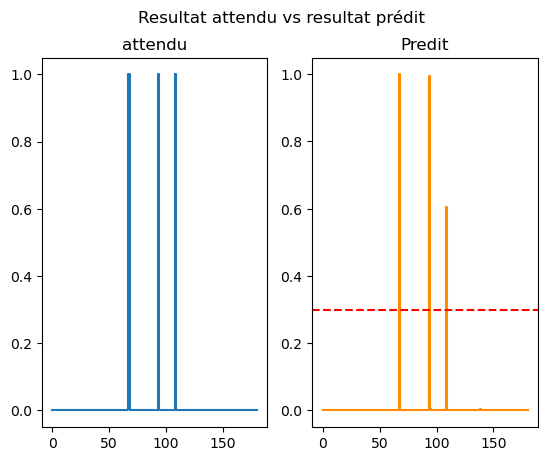

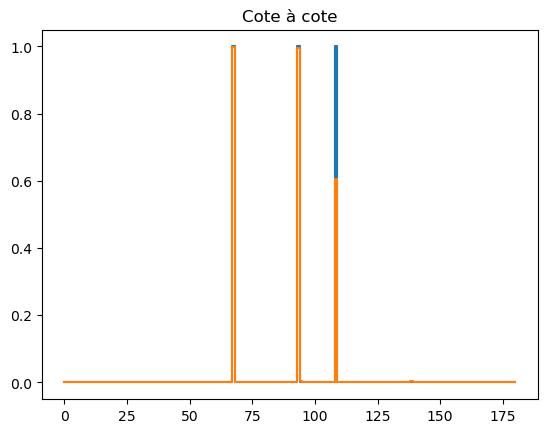

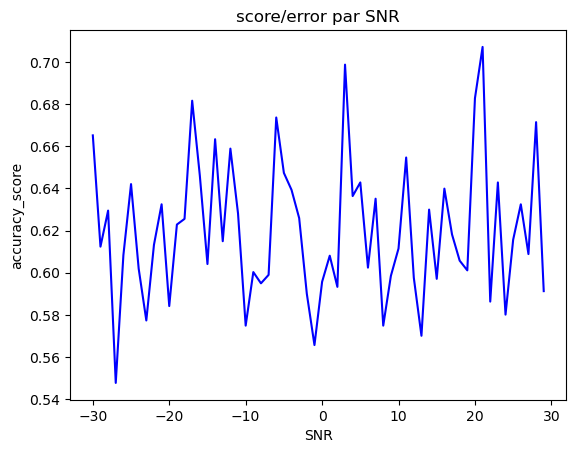

In [6]:
print(radar_dataset.X_test.shape)
threshold = 0.3

y_predicted = docuCNNModel.model.predict(radar_dataset.X_test)


randomTestIndex = random.randint(0, len(y_predicted))
PredictedStepPlot().evaluate(
    radar_dataset.y_test[randomTestIndex], y_predicted[randomTestIndex], threshold = threshold
)

y_test_pred_binary = (y_predicted > threshold).astype(int)
print("LES METRIQUES SUIVANTES SONT CALCULEES APRES AVOIR TRANSFORMER LES DONNEES DE SORTIES EN SORTIES BINAIRE AVEC UN SEUIL DE "+str(threshold))
RMSEEvaluateur().evaluate(radar_dataset.y_test, y_predicted) #take top 2 significant values
R2Score().evaluate(radar_dataset.y_test, y_test_pred_binary)
Accuracy().evaluate(radar_dataset.y_test, y_test_pred_binary)
plt.figure()
ErrorOfSNRPlot().evaluate(radar_dataset.snr_y_test, radar_dataset.y_test, y_test_pred_binary, errorFunc="accuracy_score")

## Comparaison avec l'algorithme MUSIC

In [7]:


radar_dataset_rxx = RadarDataSet.RxxDataSet(data,labels,0.4, scaler=None,appended_snr=True)
musicModel = MUSICModel(2, np.arange(-90,91,0.1))

y_music_predicted_angles, y_music_predicted_multilabel = musicModel.predict(radar_dataset_rxx.X_test)

In [8]:
print(y_music_predicted_multilabel.shape)
print(y_test_pred_binary.shape)

(7268, 181)
(7268, 181)


In [9]:
RMSEEvaluateur().evaluate(radar_dataset_rxx.y_test, y_music_predicted_multilabel) #take top 2 significant values

Root Mean square error: 44.60983474001103


44.60983474001103

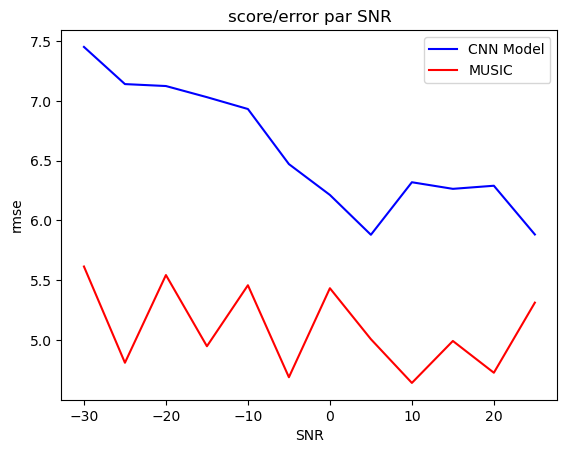

In [11]:


musicVsModelBySNRPlotter = MusicVsModelBySNR(step=5, errorFunc="rmse")
musicVsModelBySNRPlotter.evaluate(radar_dataset_rxx.snr_y_test,radar_dataset_rxx.y_test,y_music_predicted_multilabel,radar_dataset.snr_y_test,radar_dataset.y_test,y_test_pred_binary)

## Evaluation sur des données classées par SNR

In [10]:
from sklearn.metrics import f1_score
data_loader2 = DataLoader.DataLoader("./Data/Dataset_X_3S_30-30.csv","./Data/Dataset_y_3S_30-30.csv")
data2, labels2 = data_loader2.load_data()
radar_dataset2 = RadarDataSet.RealImaginaryXDataSet(data2,labels2,0.4, StandardScaler(),appended_snr=True)
threshold = 0.4
y_predicted2 = docuCNNModel.model.predict(radar_dataset2.X)
y_predicted_binary2 = (y_predicted2> threshold).astype(int)




2813/2813 [==============================] - 189s 67ms/step


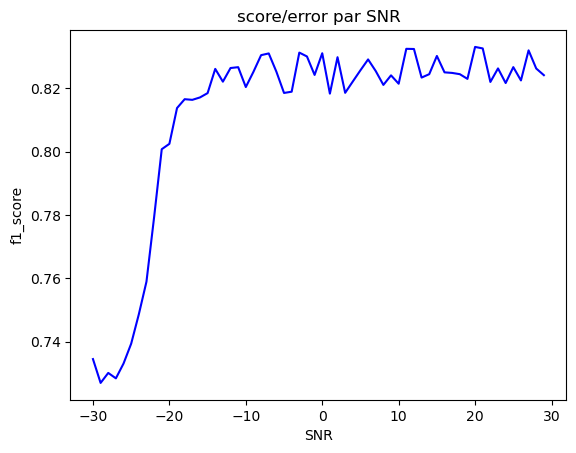

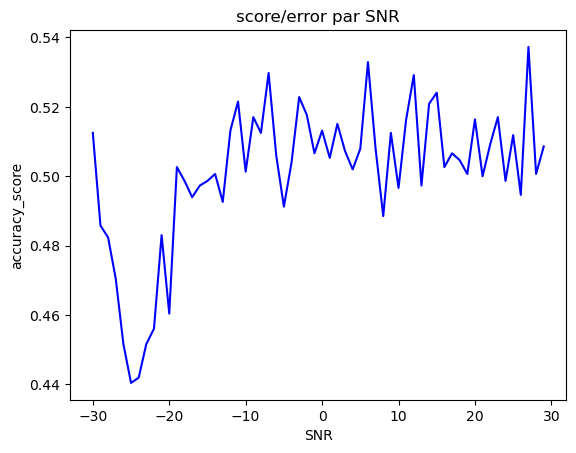

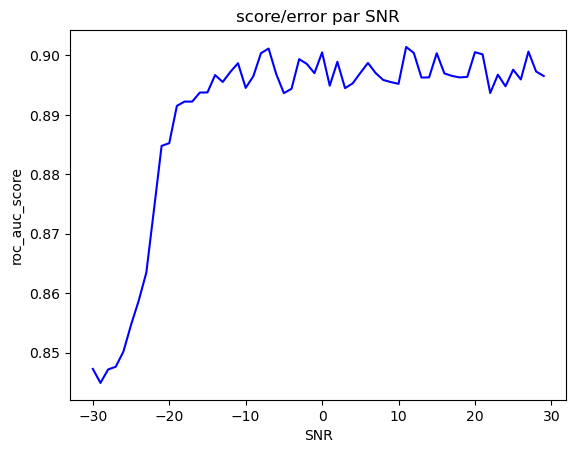

Accuracy 0.7542179207586793


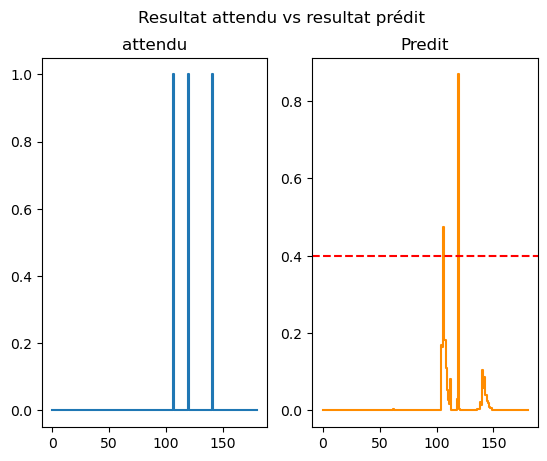

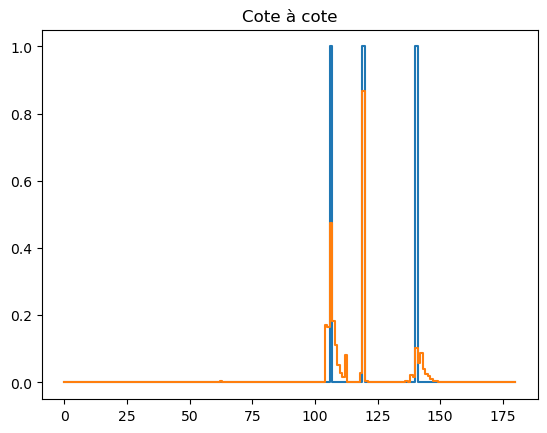

In [11]:
ErrorOfSNRPlot().evaluate(radar_dataset2.snr_y, radar_dataset2.y, y_predicted_binary2)
ErrorOfSNRPlot().evaluate(radar_dataset2.snr_y, radar_dataset2.y, y_predicted_binary2, errorFunc="accuracy_score")
ErrorOfSNRPlot().evaluate(radar_dataset2.snr_y, radar_dataset2.y, y_predicted_binary2, errorFunc="roc_auc_score")
Accuracy().evaluate(radar_dataset2.y, y_predicted_binary2)
randomTestIndex = random.randint(0, len(radar_dataset2.y))
PredictedStepPlot().evaluate(
    radar_dataset2.y[randomTestIndex], y_predicted2[randomTestIndex], threshold = threshold
)

In [ ]:
from sklearn.metrics import accuracy_score
TRESHOLDArray= np.arange(0,1,0.1)
accuracyOfTreshold = [accuracy_score(radar_dataset2.y, (y_predicted2> tresh).astype(int)) for tresh in TRESHOLDArray]

plt.plot(TRESHOLDArray,accuracyOfTreshold)

In [ ]:
accuracyOfTreshold.index(max(accuracyOfTreshold))

In [ ]:
#Distribution des labels de la dataset
nombre_exemples_par_angle = np.sum(radar_dataset2.y, axis=0)
angles = np.arange(181)-90

# Créer l'histogramme
plt.figure(figsize=(10, 6))
plt.bar(angles, nombre_exemples_par_angle, color='blue', alpha=0.7)


## Deuxieme data set SNR -30 à 30 comparaison music - model

In [ ]:

radar_dataset_rxx = RadarDataSet.RxxDataSet(data2,labels2,0.4, scaler=None,appended_snr=True)
musicModel = MUSICModel(2, np.arange(-90,91,0.1))

y_music_predicted_angles, y_music_predicted_multilabel = musicModel.predict(radar_dataset_rxx.X)


In [ ]:
y_music_predicted_multilabel.shape

In [ ]:
radar_dataset_rxx.y.shape

In [ ]:
musicVsModelBySNRPlotter = MusicVsModelBySNR(step=5, errorFunc="rmse") #Illustrer le CRB limite theorique
musicVsModelBySNRPlotter.evaluate(radar_dataset_rxx.snr_y,radar_dataset_rxx.y,y_music_predicted_multilabel,radar_dataset2.snr_y, radar_dataset2.y, y_predicted_binary2, errorFunc="rmse", step=5)

In [ ]:
# Faire un diagramme pour Deux sources et un autre pour trois sources

In [ ]:
tf.losses.binary_crossentropy(np.asarray([[1,0,0,0,0],[0,0,1,0,0]],dtype=np.float32),np.asarray([[0,1,0,0,0],[0,0,0,1,0]],dtype=np.float32),axis=1)

In [ ]:
df = pd.DataFrame({'SNR': radar_dataset_rxx.snr_y, 'y_true': list(radar_dataset_rxx.y), 'y_pred': list(y_music_predicted_multilabel)})

In [ ]:
df.query("SNR % 5 == 0")

In [ ]:
df = pd.DataFrame({'SNR': radar_dataset_rxx.snr_y, 'y_true': list(radar_dataset_rxx.y), 'y_pred': list(y_music_predicted_multilabel)})
df_music = pd.DataFrame({'SNR': radar_dataset2.snr_y, 'y_true': list(radar_dataset2.y), 'y_pred': list(y_predicted_binary2)})
df = df.query("SNR % 5 == 0")
df_music = df_music.query("SNR % 2 == 0")
rmse_values_model = df.groupby('SNR').apply(lambda group: np.sqrt(RMSEEvaluateur().evaluate(np.array(group['y_true'].tolist()), np.array(group['y_pred'].tolist()),Nsources=2, verbose=False)))
rmse_values_music = df_music.groupby('SNR').apply(lambda group: np.sqrt(RMSEEvaluateur().evaluate(np.array(group['y_true'].tolist()), np.array(group['y_pred'].tolist()),Nsources=2, verbose=False)))
plt.title("Music VS CNN Model "+str(2)+" Sources")
plt.plot(rmse_values_model.index, rmse_values_model, color='blue', label="CNN Model")
plt.plot(rmse_values_music.index, rmse_values_music, color='red', label = "MUSIC")
plt.legend()
# Ajoutez des étiquettes et un titre
plt.xlabel('SNR')
plt.ylabel("rmse")
plt.title('score/error par SNR')